In [12]:
import ase
from ase.visualize.plot import plot_atoms
from ase.visualize import view

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from skimage.morphology import local_maxima
from skimage.feature import peak_local_max

from molnet.data.utils import get_image_and_atom_map_np

In [2]:
def generator():
    for i in range(1000):
        x, y, xyz = get_image_and_atom_map_np(
            '/l/data/small_fragments/afm.h5',
            i,
            np.array([1, 6, 7, 8, 9]),
            "train",
            2.0,
            0.125,
            0.3
        )
        if x is None:
            continue

        yield x, y, xyz

gen = generator()

(128, 128, 10) (5, 128, 128, 20) (28, 5)


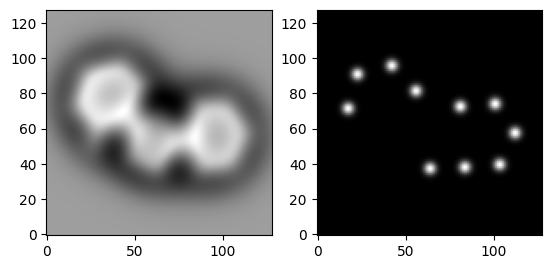

In [3]:
x, y, xyz = next(gen)
print(x.shape, y.shape, xyz.shape)

ax = plt.subplot(1, 2, 1)
ax.imshow(x[:, :, 0], cmap='gray', origin='lower')
ax = plt.subplot(1, 2, 2)
ax.imshow(y[0].sum(axis=(-1)), cmap='gray', origin='lower')

In [4]:
peaks = peak_local_max(y, min_distance=6, threshold_rel=0.1, exclude_border=0)
print(peaks.shape)

(28, 4)


In [5]:
scan_window = np.array(
    [
        [2.0, 2.0, 0.0],
        [18.0, 18.0, 2.0]
    ]
)

In [6]:
# convert peaks into xyz coordinates using the scan window
index_to_species = {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F'}
peaks_xyz = peaks[:, [2, 1, 3]] * (scan_window[1]-scan_window[0]) / y.shape[1:]
peaks_z = peaks[:, 0]
mol_pred = ase.Atoms(
    positions=peaks_xyz,
    symbols=[index_to_species[i] for i in peaks_z],
    cell=(16, 16, 2)
)

mol_dataset = ase.Atoms(
    positions=xyz[:, :3],
    numbers=xyz[:, -1],
    cell=(16, 16, 2)
)

view([mol_dataset, mol_pred])

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/molnet/bin/python...>

In [7]:
print(y.shape)
f = RegularGridInterpolator(
    (
        np.arange(y.shape[0]),
        np.linspace(scan_window[0, 0], scan_window[1, 0], y.shape[1]),
        np.linspace(scan_window[0, 1], scan_window[1, 1], y.shape[2]),
        np.linspace(scan_window[0, 2], scan_window[1, 2], y.shape[3])
    ),
    y,
    method='linear',
)

(5, 128, 128, 20)


In [8]:
elems = np.arange(y.shape[0])
xm = np.linspace(scan_window[0, 0], scan_window[1, 0], y.shape[1])
ym = np.linspace(scan_window[0, 1], scan_window[1, 1], y.shape[2])
zm = np.linspace(scan_window[0, 2], scan_window[1, 2], 100)
e, X, Y, Z = np.meshgrid(elems, xm, ym, zm, indexing='ij')
grid = np.stack([e, X, Y, Z], axis=-1)


In [9]:
y_int = f(grid)

In [10]:
peaks_int = peak_local_max(y_int, min_distance=1, threshold_rel=0.1, exclude_border=0)
peaks_xyz_int = peaks_int[:, [2, 1, 3]] * (scan_window[1]-scan_window[0]) / y_int.shape[1:]
peaks_z_int = peaks_int[:, 0]

mol_pred_int = ase.Atoms(
    positions=peaks_xyz_int,
    symbols=[index_to_species[i] for i in peaks_z_int],
)

In [11]:
view([mol_dataset, mol_pred_int, mol_pred])

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/molnet/bin/python...>

<Axes: >

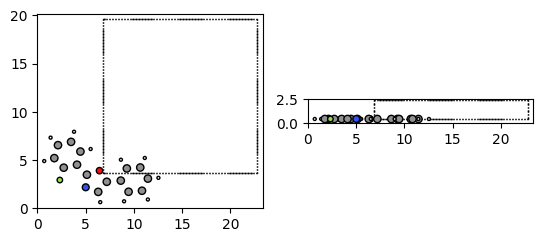

In [23]:
ax = plt.subplot(1, 2, 1)
plot_atoms(mol_dataset, ax, radii=0.5, rotation='0x,0y', show_unit_cell=2)

ax = plt.subplot(1, 2, 2)
plot_atoms(mol_dataset, ax, radii=0.5, rotation='-90x,0y', show_unit_cell=2)